<a href="https://colab.research.google.com/github/gyaneshhere/LLM-Security-and-Observability/blob/main/LangFuse/Develop/LLMObservability/multiAgentApp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Multi agent application with LangGraph
## What we will do in this section:

Build One research agent using the LangChain WikipediaAPIWrapper to search Wikipedia and one that uses a custom tool to get the current time.
Build an agent supervisor to help delegate the user questions to one of the two agents
Add Langfuse handler as callback to trace the steps of the supervisor and executing agents

In [11]:
%pip install langgraph langchain langchain_openai langchain_experimental pandas wikipedia langfuse

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.0/275.0 kB 9.9 MB/s eta 0:00:00


In [16]:
from google.colab import userdata


In [17]:
import os

# get keys for your project from https://cloud.langfuse.com
os.environ["LANGFUSE_PUBLIC_KEY"] = userdata.get('LANGFUSE_PUBLIC_KEY')
os.environ["LANGFUSE_SECRET_KEY"] = userdata.get('LANGFUSE_SECRET_KEY')
#os.environ["LANGFUSE_HOST"] = "https://cloud.langfuse.com" # for EU data region
os.environ["LANGFUSE_HOST"] = "https://us.cloud.langfuse.com" # for US data region



**Create tools**

For this example, you build an agent to do wikipedia research, and one agent to tell you the current time. Define the tools they will use below:

In [18]:
from typing import Annotated

from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from datetime import datetime
from langchain.tools import Tool

# Define a tools that searches Wikipedia
wikipedia_tool = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())

# Define a new tool that returns the current datetime
datetime_tool = Tool(
    name="Datetime",
    func = lambda x: datetime.now().isoformat(),
    description="Returns the current datetime",
)


**Helper utilities**

Define a helper function below to simplify adding new agent worker nodes.

In [19]:
from langchain.agents import AgentExecutor, create_openai_tools_agent
from langchain_core.messages import BaseMessage, HumanMessage
from langchain_openai import ChatOpenAI

def create_agent(llm: ChatOpenAI, system_prompt: str, tools: list):
    # Each worker node will be given a name and some tools.
    prompt = ChatPromptTemplate.from_messages(
        [
            (
                "system",
                system_prompt,
            ),
            MessagesPlaceholder(variable_name="messages"),
            MessagesPlaceholder(variable_name="agent_scratchpad"),
        ]
    )
    agent = create_openai_tools_agent(llm, tools, prompt)
    executor = AgentExecutor(agent=agent, tools=tools)
    return executor

def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {"messages": [HumanMessage(content=result["output"], name=name)]}

**Create agent supervisor**

It will use function calling to choose the next worker node OR finish processing.

In [20]:
# your openai key
import os
from google.colab import userdata
os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

In [21]:
from langchain_core.output_parsers.openai_functions import JsonOutputFunctionsParser
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

members = ["Researcher", "CurrentTime"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process and decides when the work is completed
options = ["FINISH"] + members

# Using openai function calling can make output parsing easier for us
function_def = {
    "name": "route",
    "description": "Select the next role.",
    "parameters": {
        "title": "routeSchema",
        "type": "object",
        "properties": {
            "next": {
                "title": "Next",
                "anyOf": [
                    {"enum": options},
                ],
            }
        },
        "required": ["next"],
    },
}

# Create the prompt using ChatPromptTemplate
prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))

llm = ChatOpenAI(model="gpt-4o")

# Construction of the chain for the supervisor agent
supervisor_chain = (
    prompt
    | llm.bind_functions(functions=[function_def], function_call="route")
    | JsonOutputFunctionsParser()
)

###Add Langfuse as callback to the invocation

Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}

In [22]:
import functools
import operator
from typing import Sequence, TypedDict
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langgraph.graph import END, StateGraph, START

# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str

# Add the research agent using the create_agent helper function
research_agent = create_agent(llm, "You are a web researcher.", [wikipedia_tool])
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# Add the time agent using the create_agent helper function
currenttime_agent = create_agent(llm, "You can tell the current time at", [datetime_tool])
currenttime_node = functools.partial(agent_node, agent=currenttime_agent, name = "CurrentTime")

workflow = StateGraph(AgentState)

# Add a "chatbot" node. Nodes represent units of work. They are typically regular python functions.
workflow.add_node("Researcher", research_node)
workflow.add_node("CurrentTime", currenttime_node)
workflow.add_node("supervisor", supervisor_chain)

# We want our workers to ALWAYS "report back" to the supervisor when done
for member in members:
    workflow.add_edge(member, "supervisor")

# Conditional edges usually contain "if" statements to route to different nodes depending on the current graph state.
# These functions receive the current graph state and return a string or list of strings indicating which node(s) to call next.
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)

# Add an entry point. This tells our graph where to start its work each time we run it.
workflow.add_edge(START, "supervisor")

# To be able to run our graph, call "compile()" on the graph builder. This creates a "CompiledGraph" we can use invoke on our state.
graph_2 = workflow.compile()

In [23]:
from langfuse.callback import CallbackHandler

# Initialize Langfuse CallbackHandler for Langchain (tracing)
langfuse_handler = CallbackHandler()

# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
# You can also set an optional 'run_name' that will be used as the trace name in Langfuse
for s in graph_2.stream({"messages": [HumanMessage(content = "How does photosynthesis work?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content="Photosynthesis is a biological process used by photosynthetic organisms, including most plants, algae, and cyanobacteria, to convert light energy, typically from sunlight, into chemical energy. This chemical energy is stored within organic compounds like sugars, glycogen, cellulose, and starches. Here’s how the process works:\n\n1. **Light Absorption**: Photosynthesis starts when light energy is absorbed by reaction centers that contain photosynthetic pigments. In plants, these pigments are chlorophylls located in chloroplasts within leaf cells.\n\n2. **Light-Dependent Reactions**: The absorbed light energy is used to split water molecules, releasing oxygen gas and freeing hydrogen. This hydrogen is used to create important molecules such as ATP (adenosine triphosphate) and NADPH (reduced nicotinamide adenine dinucleotide phosphate), essential for energy transfer.\n\n3. **Calvin Cycle (Light-

In [13]:
# Add Langfuse handler as callback: config={"callbacks": [langfuse_handler]}
for s in graph_2.stream({"messages": [HumanMessage(content = "What time is it?")]},
                      config={"callbacks": [langfuse_handler]}):
    print(s)
    print("----")

{'supervisor': {'next': 'CurrentTime'}}
----
{'CurrentTime': {'messages': [HumanMessage(content='The current time is 03:27 AM on April 19, 2025.', additional_kwargs={}, response_metadata={}, name='CurrentTime')]}}
----
{'supervisor': {'next': 'FINISH'}}
----


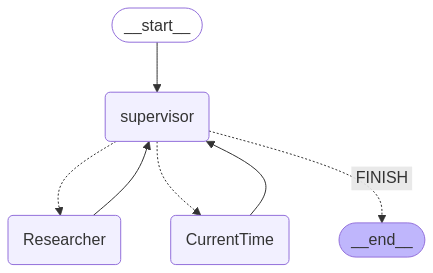

In [14]:
from IPython.display import Image, display
display(Image(graph_2.get_graph().draw_mermaid_png()))

In [15]:
from langfuse.decorators import langfuse_context, observe

# Langfuse observe() decorator to automatically create a trace for the top-level function and spans for any nested functions.
@observe()
def research_agent(user_message):
    # Get callback handler scoped to this observed function
    lf_handler = langfuse_context.get_current_langchain_handler()

    # Trace langchain run via the Langfuse CallbackHandler
    response = graph_2.invoke({"messages": [HumanMessage(content=user_message)]},
                        config={"callbacks": [lf_handler]})

    # Score the entire trace e.g. to add user feedback
    langfuse_context.score_current_trace(
        name = "user-explicit-feedback",
        value = 1,
        comment = "The time is correct!"
        )

    return response
research_agent("What time is it?")

{'messages': [HumanMessage(content='What time is it?', additional_kwargs={}, response_metadata={}),
  HumanMessage(content='The current time is 03:29 AM on April 19, 2025.', additional_kwargs={}, response_metadata={}, name='CurrentTime')],
 'next': 'FINISH'}

**Example Trace**

https://us.cloud.langfuse.com/project/cm6lmc14y022zvate2r5eb0xy/traces/ed59090d-4c31-4f9d-b846-1ec327549283?timestamp=2025-04-19T03:32:33.487Z&display=details

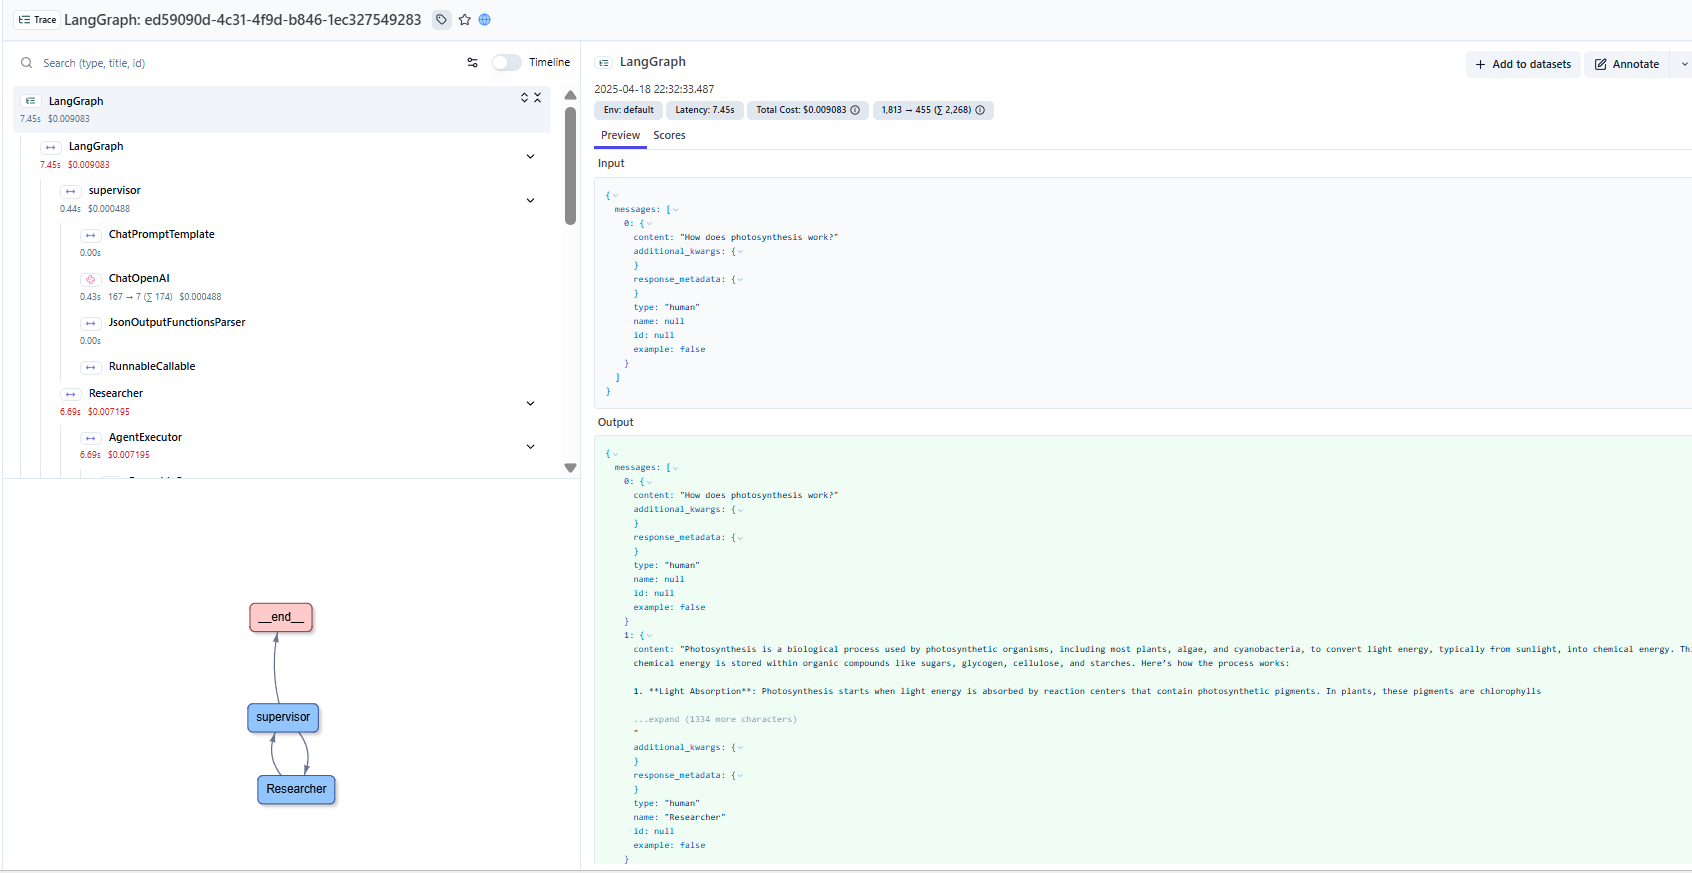